In [588]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score,r2_score
import itertools
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [589]:
data = "processed_dataset.csv"
# processed_dataset_powerprod.csv       Classifies outliers, this means additional features in model, with the goal of fitting the model better to power production
# processed_dataset.csv      This file deletes all outliers, max pre-processing, deletes cp values etc

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [590]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [591]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

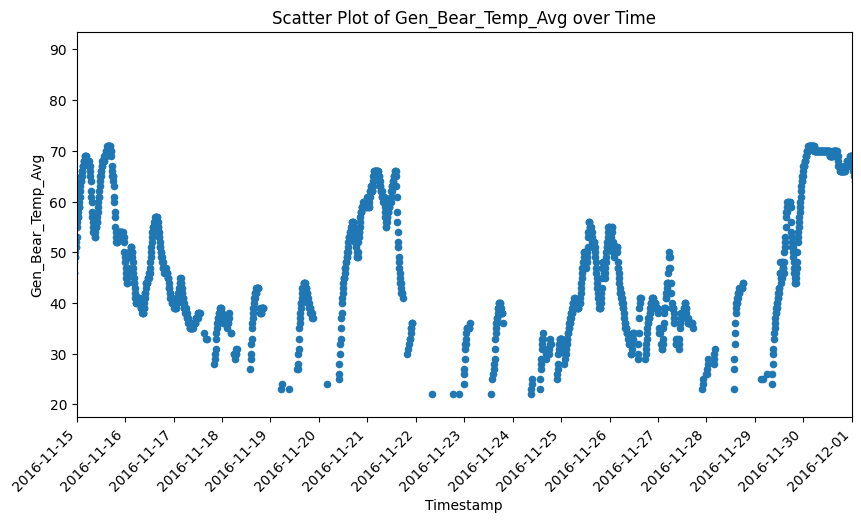

In [592]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


## Custom features

In [593]:
# creating data columns for the xgboost regressor

# Air density

# acceleration last x seconds

# Can we implement average speed for the last 30 minutes

# C_p?

# tip speed ratio

# Angle of blades

# Wind direction

# wind speed modified for distributed wind speed on diameter of blade

Air density 

In [594]:

# https://wahiduddin.net/calc/density_altitude.htm

# def Calculate_Air_Density(temperature, pressure, humidity):
def Calculate_Air_Density(data_dict={}):

	temperature =  data_dict.get('temperature', 0)
	pressure = data_dict.get('pressure', 0) * 100
	humidity = data_dict.get('humidity', 0)

#	print (f'temperature = {temperature}, pressure = {pressure}, humidity = {humidity}')
#	print ('')

	# Constants
	R_specific_dry_air = 287.05  # Specific gas constant for dry air in J/(kg·K)

	# Convert temperature to Kelvin
	temperature_k = temperature + 273.15

	# Calculate water vapor pressure
	e_s = 6.1078 * 10 ** ((7.5 * temperature) / (237.3 + temperature))  # Saturation vapor pressure (Tetens' Formula)
	e = humidity * e_s / 100.0  # Vapor pressure

	# Calculate specific humidity
	q = 0.622 * e / (pressure - 0.378 * e)

	# Calculate air density
	rho_dry_air = pressure / (R_specific_dry_air * temperature_k)
	rho_water_vapor = q / temperature_k

	# Total air density
	rho_air = rho_dry_air + rho_water_vapor

	return rho_air


In [595]:


# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df["T"] = merged_df["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df["p"] = merged_df["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df["e_s"] = 6.112 * np.exp((17.67 * merged_df["Amb_Temp_Avg"]) / (merged_df["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df["RH_frac"] = merged_df["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df["p_v"] = merged_df["RH_frac"] * merged_df["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df["p_d"] = merged_df["p"] - merged_df["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df["airdensity"] = (merged_df["p_d"] / (R_d * merged_df["T"])) + (merged_df["p_v"] / (R_v * merged_df["T"]))

# Optionally, drop intermediate columns if not needed
merged_df.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df[["airdensity"]].head())


   airdensity
0    1.193996
1    1.203438
2    1.203356
3    1.204229
4    1.194742


In [596]:
# Define gas constants for dry air and water vapor in J/(kg*K)
R_d = 287.058  
R_v = 461.495  

# Convert temperature to Kelvin and pressure to Pascals
merged_df17["T"] = merged_df17["Amb_Temp_Avg"] + 273.15         # Temperature in Kelvin
merged_df17["p"] = merged_df17["Avg_Pressure"] * 100              # Total pressure in Pa

# Calculate saturation vapor pressure (in Pa) using the Magnus formula
# 6.112 hPa is converted to Pa by multiplying by 100
merged_df17["e_s"] = 6.112 * np.exp((17.67 * merged_df17["Amb_Temp_Avg"]) / (merged_df17["Amb_Temp_Avg"] + 243.5)) * 100

# Convert relative humidity from percentage to a fraction using "Avg_Humidity"
merged_df17["RH_frac"] = merged_df17["Avg_Humidity"] / 100.0

# Calculate the actual water vapor pressure (in Pa)
merged_df17["p_v"] = merged_df17["RH_frac"] * merged_df17["e_s"]

# Calculate the partial pressure of dry air (in Pa)
merged_df17["p_d"] = merged_df17["p"] - merged_df17["p_v"]

# Compute air density (kg/m^3) as the sum of dry air and water vapor contributions
merged_df17["airdensity"] = (merged_df17["p_d"] / (R_d * merged_df17["T"])) + (merged_df17["p_v"] / (R_v * merged_df17["T"]))

# Optionally, drop intermediate columns if not needed
merged_df17.drop(columns=["T", "p", "e_s", "RH_frac", "p_v", "p_d"], inplace=True)

print(merged_df17[["airdensity"]].head())


    airdensity
3     1.221427
12    1.225975
19    1.225897
21    1.226208
22    1.226286


(-50.0, 2100.0)

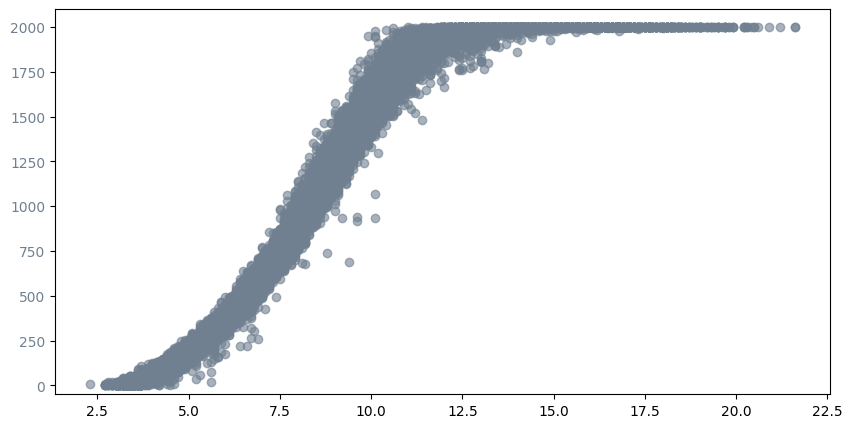

In [597]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df["Amb_WindSpeed_Avg"], merged_df["Grd_Prod_Pwr_Avg"], color='slategray', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)


## Start mechanistic model

In [598]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df["tsr"] = (merged_df["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df["Amb_WindSpeed_Avg"]

merged_df = merged_df[merged_df["Amb_WindSpeed_Avg"] != 0]

In [599]:
# Tip Speed Ratio (TSR)

conversion_factor = 2 * np.pi / 60
rotor_diameter = 90

merged_df17["tsr"] = (merged_df17["Rtr_RPM_Avg"]* conversion_factor) * (rotor_diameter/2) / merged_df17["Amb_WindSpeed_Avg"]

merged_df17 = merged_df17[merged_df17["Amb_WindSpeed_Avg"] != 0]

In [600]:
# calculate wind power column
# Calculate actual cp

"""Amb_Temp_Avg, Avg_AmbientTemp"""
Arotor = 6362 #m^2 rotor area

# new column for power in the wind itself. 
merged_df["p_wind"] = 0.5*merged_df["airdensity"]*Arotor*(merged_df["Amb_WindSpeed_Avg"]**3)/1000 #kW

merged_df = merged_df[merged_df["p_wind"] != 0]
# cp = p_turbine / p_wind
merged_df["cp_actual"] =  merged_df["Grd_Prod_Pwr_Avg"] / merged_df["p_wind"]

merged_df = merged_df[merged_df["cp_actual"] != 0]

In [601]:
# calculate wind power column
# Calculate actual cp

# new column for power in the wind itself. 
merged_df17["p_wind"] = 0.5*merged_df17["airdensity"]*Arotor*(merged_df17["Amb_WindSpeed_Avg"]**3)/1000 #kW


In [602]:
"""print(y_train.isna().sum())  # Count NaNs
print(np.isinf(y_train).sum())  # Count infinities"""

'print(y_train.isna().sum())  # Count NaNs\nprint(np.isinf(y_train).sum())  # Count infinities'

## Xgboost model:

With hyperparameters from Olivers thesis:

In [603]:
# Step 2: Specify the feature columns and the target variable
feature_columns = ["Avg_Pressure", "Avg_Humidity", "Amb_Temp_Avg", "Gen_RPM_Avg", "Amb_WindSpeed_Avg"]  # Features
target_column = 'Grd_Prod_Pwr_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model with optimal hyperparameters
model = XGBRegressor()

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)

# Step 8: Evaluate the model on merged_df (Optional)
train_predictions = model.predict(X_train)

# Check if the target variable is binary (classification)
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # Regression Metrics
    mse = mean_squared_error(y_train, train_predictions)
    mae = mean_absolute_error(y_train, train_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train, train_predictions)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100
    
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    print(f'R² Score: {r2:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


Mean Squared Error (MSE): 648.58
Mean Absolute Error (MAE): 17.82
Root Mean Squared Error (RMSE): 25.47
R² Score: 1.00
Mean Absolute Percentage Error (MAPE): 15.37%


# Error evaluation

In [604]:
# mean error of hybrid model
y_difference_xgboost = merged_df17["xgboost_pred_2017"] - merged_df17["Grd_Prod_Pwr_Avg"]

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_xgboost = np.abs(np.std(y_difference_xgboost))

In [605]:
modelling_error_xgboost


np.float64(165.03094396018983)

(-50.0, 2100.0)

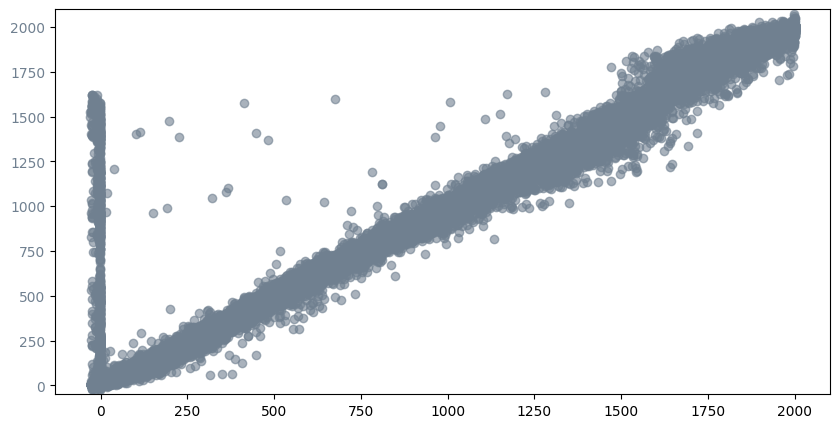

In [606]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df17["Grd_Prod_Pwr_Avg"], merged_df17["xgboost_pred_2017"], color='slategray', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)

(-50.0, 2100.0)

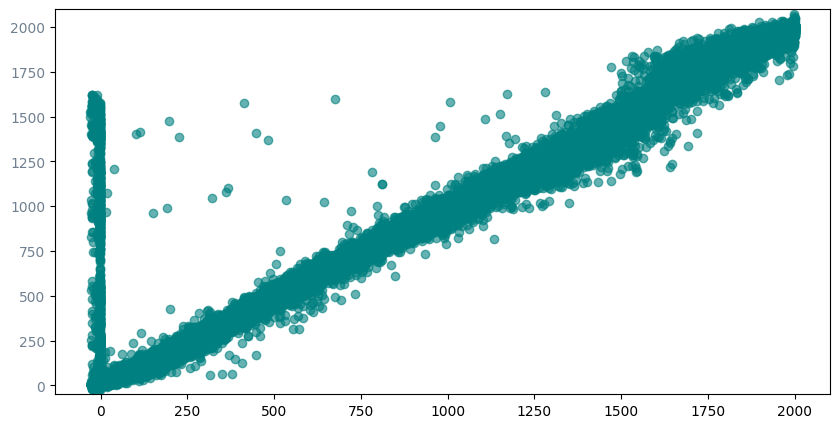

In [607]:
# Create a secondary y-axis with a slate gray color
plt.scatter(merged_df17["Grd_Prod_Pwr_Avg"], merged_df17["xgboost_pred_2017"], color='teal', label='Wind Power (W)', alpha=0.6)  # Muted slate gray color
  # Secondary y-axis label color
plt.tick_params(axis='y', labelcolor='slategray')  # Secondary y-axis label tick color
plt.ylim(-50, 2100)


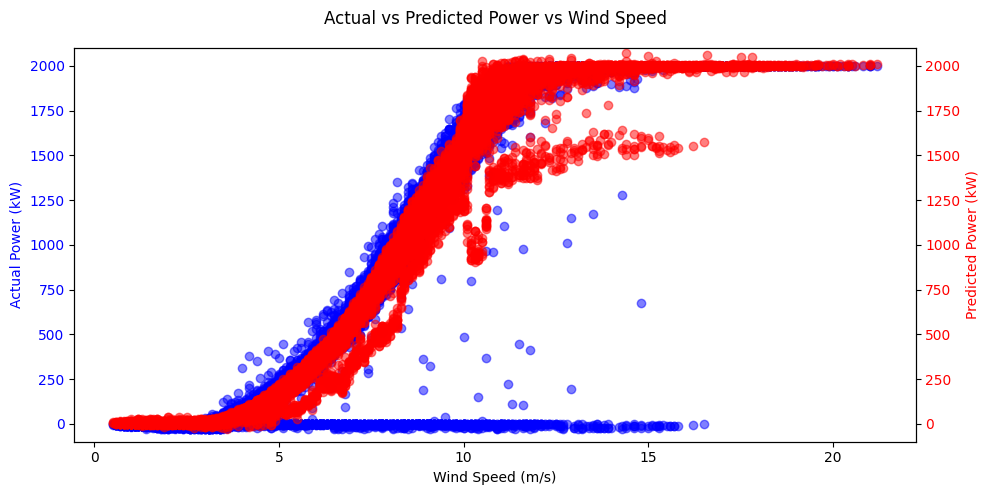

In [608]:
import matplotlib.pyplot as plt

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = merged_df17["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = merged_df17["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = merged_df17["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="blue")
ax1.scatter(x, y_actual, color="blue", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="blue")
plt.ylim(-100,2100)
# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="red")
ax2.scatter(x, y_predicted, color="red", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="red")


# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed")
fig.tight_layout()
plt.ylim(-100,2100)
plt.show()


In [609]:
print(merged_df17.columns)


Index(['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg',
       'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
       ...
       'Anemometer2_CorrOffset', 'DistanceAirPress',
       'AirRessureSensorZeroOffset', 'Anemometer1_Avg_Freq',
       'Anemometer2_Avg_Freq', 'Pressure_Avg_Freq', 'airdensity', 'tsr',
       'p_wind', 'xgboost_pred_2017'],
      dtype='object', length=127)


### What does this look for a smaller period

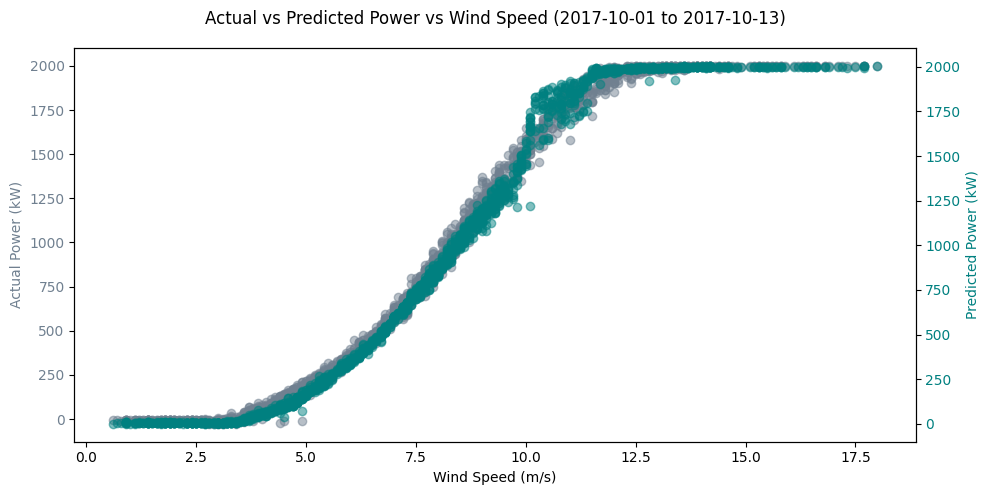

In [610]:
import matplotlib.pyplot as plt

# Ensure timestamp is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Filter data for the date range 2017-10-01 to 2017-10-13
filtered_df = merged_df17[(merged_df17["Timestamp"] >= "2017-10-01") & 
                          (merged_df17["Timestamp"] <= "2017-10-13")]

# Define x (Windspeed), y1 (Actual), and y2 (Predicted)
x = filtered_df["Amb_WindSpeed_Avg"]  # Wind speed (X-axis)
y_actual = filtered_df["Grd_Prod_Pwr_Avg"]  # Actual power production (Left Y-axis)
y_predicted = filtered_df["xgboost_pred_2017"]  # Predicted power production (Right Y-axis)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot actual values on left y-axis
ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_ylabel("Actual Power (kW)", color="slategrey")
ax1.scatter(x, y_actual, color="slategrey", label="Actual Power", alpha=0.5)
ax1.tick_params(axis="y", labelcolor="slategrey")

# Create a second y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Predicted Power (kW)", color="teal")
ax2.scatter(x, y_predicted, color="teal", label="Predicted Power", alpha=0.5)
ax2.tick_params(axis="y", labelcolor="teal")

# Add title and show legend
fig.suptitle("Actual vs Predicted Power vs Wind Speed (2017-10-01 to 2017-10-13)")
fig.tight_layout()
plt.show()


In [661]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Compute metrics
mse = mean_squared_error(y_actual, y_predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_predicted)
r2 = r2_score(y_actual, y_predicted)
mape = mean_absolute_percentage_error(y_actual,y_predicted)
# Print metrics
print("Model Performance Metrics (2017-10-01 to 2017-10-13):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"MAPE Score: {mape:.4f}")
print(f"R² Score: {r2:.4f}")


Model Performance Metrics (2017-10-01 to 2017-10-13):
Mean Squared Error (MSE): 2766.01
Root Mean Squared Error (RMSE): 52.59
Mean Absolute Error (MAE): 33.28
MAPE Score: 0.5025
R² Score: 0.9949


### Error calculation

In [611]:
# error models

# total error = model error + sensor error + actual error + operational error

# Percentage mode


# mean error
y_difference = y_predicted-y_actual

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error = np.abs(np.std(y_difference))

In [612]:
modelling_error

np.float64(52.57050539480342)

In [613]:
# mean error of hybrid model
y_difference_inference = filtered_df["xgboost_pred_2017"] - filtered_df["Grd_Prod_Pwr_Avg"]

# "modelling_error" is going to be used to visualize the errors in all plots going forward
modelling_error_inference = np.abs(np.std(y_difference_inference))

In [614]:
modelling_error_inference

np.float64(52.57050539480342)

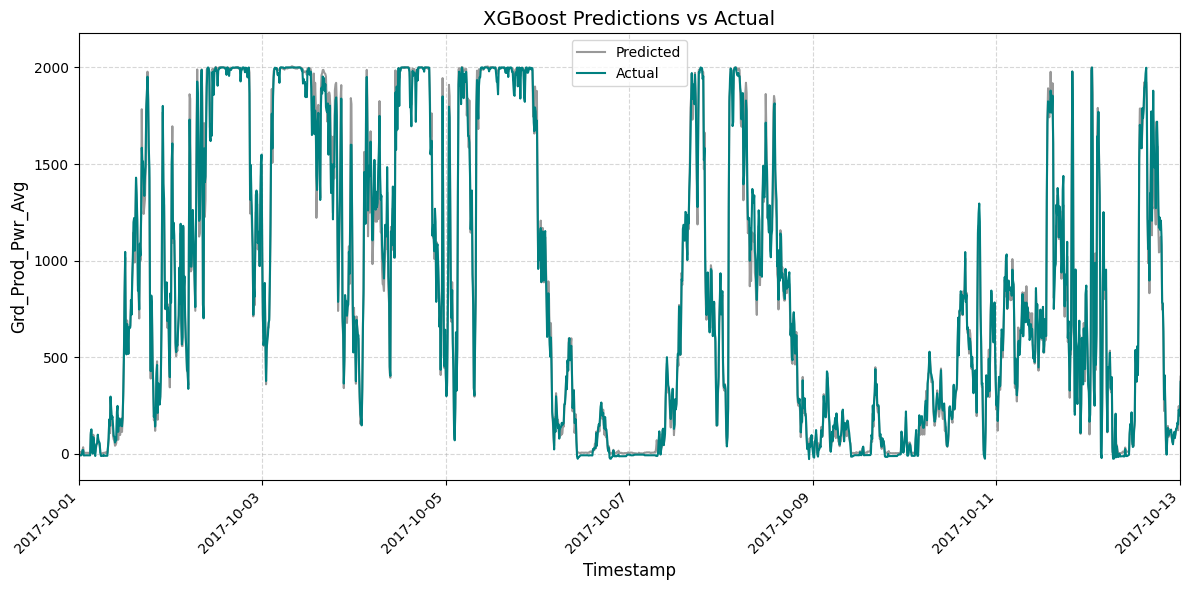

In [615]:
# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
filtered_df = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    filtered_df["Timestamp"],  # Sorted timestamps
    filtered_df["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)
plt.plot(
    filtered_df["Timestamp"],  # Sorted timestamps
    filtered_df[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)
# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [616]:
modelling_error_inference

np.float64(52.57050539480342)

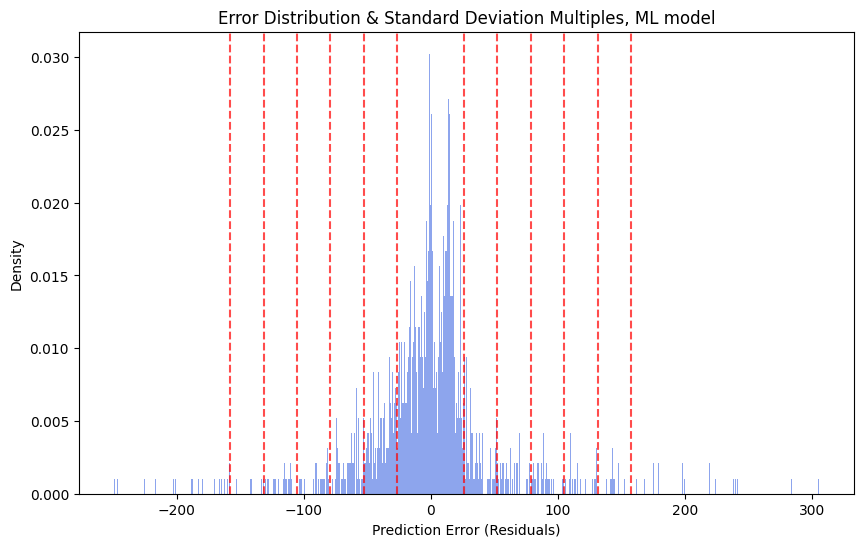

In [654]:

# Compute standard deviation of errors
std_dev = np.std(y_difference_inference)

# Define thresholds (multiples of sigma)
multiples_of_sigma = np.arange(0.5, 3.5, 0.5)  # From 0.5σ to 3σ
coverage_percentages = [(np.abs(y_difference_inference) <= m * std_dev).mean() * 100 for m in multiples_of_sigma]

plt.figure(figsize=(10, 6))
plt.hist(y_difference_inference, bins=1000, alpha=0.6, color='royalblue', density=True)

# Add vertical lines for standard deviation multiples
for m in multiples_of_sigma:
    plt.axvline(m * std_dev, color='red', linestyle='dashed', alpha=0.7)
    plt.axvline(-m * std_dev, color='red', linestyle='dashed', alpha=0.7)

plt.title("Error Distribution & Standard Deviation Multiples, ML model")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Density")
plt.show()


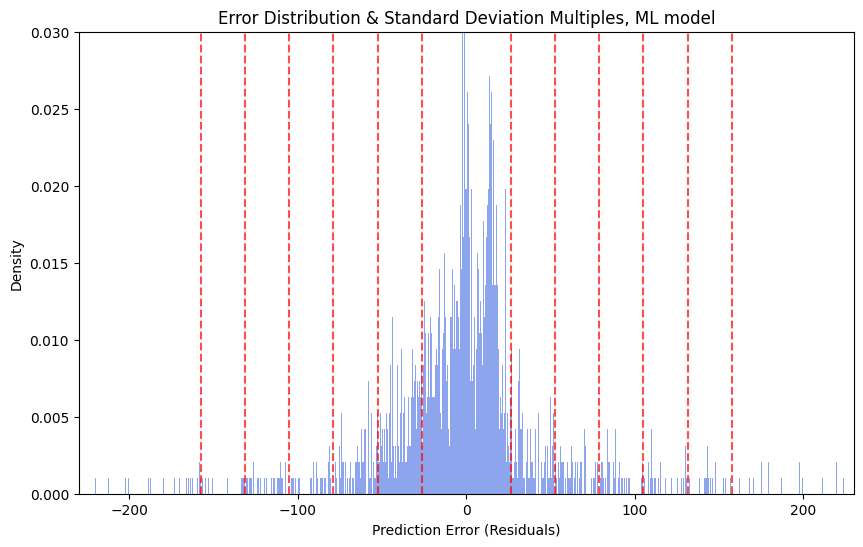

In [657]:

# Compute standard deviation of errors
std_dev = np.std(y_difference_inference)

# Define thresholds (multiples of sigma)
multiples_of_sigma = np.arange(0.5, 3.5, 0.5)  # From 0.5σ to 3σ
coverage_percentages = [(np.abs(y_difference_inference) <= m * std_dev).mean() * 100 for m in multiples_of_sigma]

plt.figure(figsize=(10, 6))
plt.hist(y_difference_inference, bins=1000, alpha=0.6, color='royalblue', density=True)

# Add vertical lines for standard deviation multiples
for m in multiples_of_sigma:
    plt.axvline(m * std_dev, color='red', linestyle='dashed', alpha=0.7)
    plt.axvline(-m * std_dev, color='red', linestyle='dashed', alpha=0.7)

plt.title("Error Distribution & Standard Deviation Multiples, ML model")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Density")
plt.xlim(-230,230)
plt.ylim(0,0.03)
plt.show()


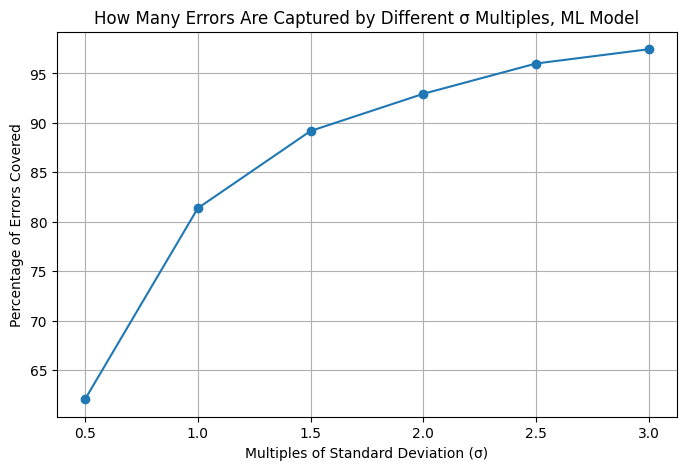

In [658]:
plt.figure(figsize=(8, 5))
plt.plot(multiples_of_sigma, coverage_percentages, marker='o', linestyle='-')

plt.xlabel("Multiples of Standard Deviation (σ)")
plt.ylabel("Percentage of Errors Covered")
plt.title("How Many Errors Are Captured by Different σ Multiples, ML Model")
plt.grid(True)

plt.show()

In [659]:
coverage_percentages


[np.float64(62.05899363794101),
 np.float64(81.37651821862349),
 np.float64(89.1844997108155),
 np.float64(92.9438982070561),
 np.float64(96.00925390399074),
 np.float64(97.45517640254482)]

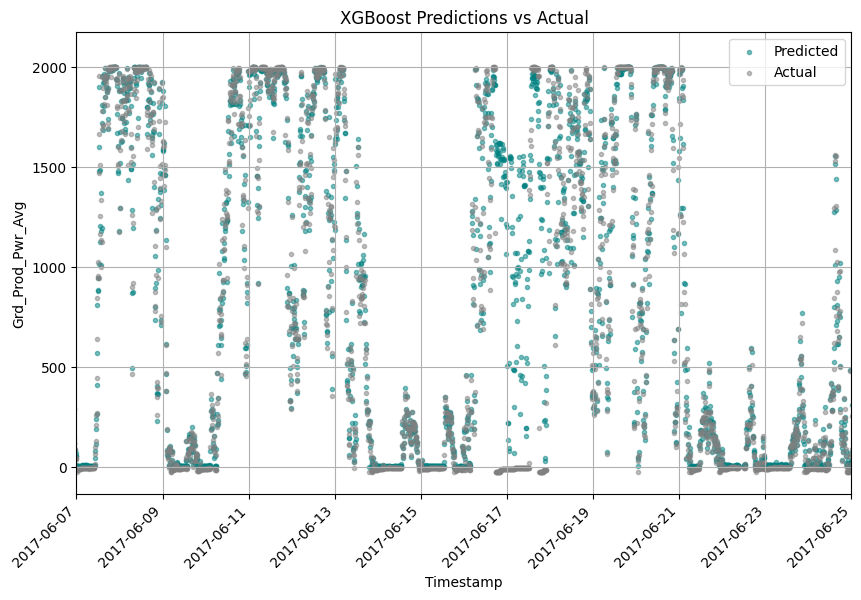

In [620]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


## Set maximum power here:

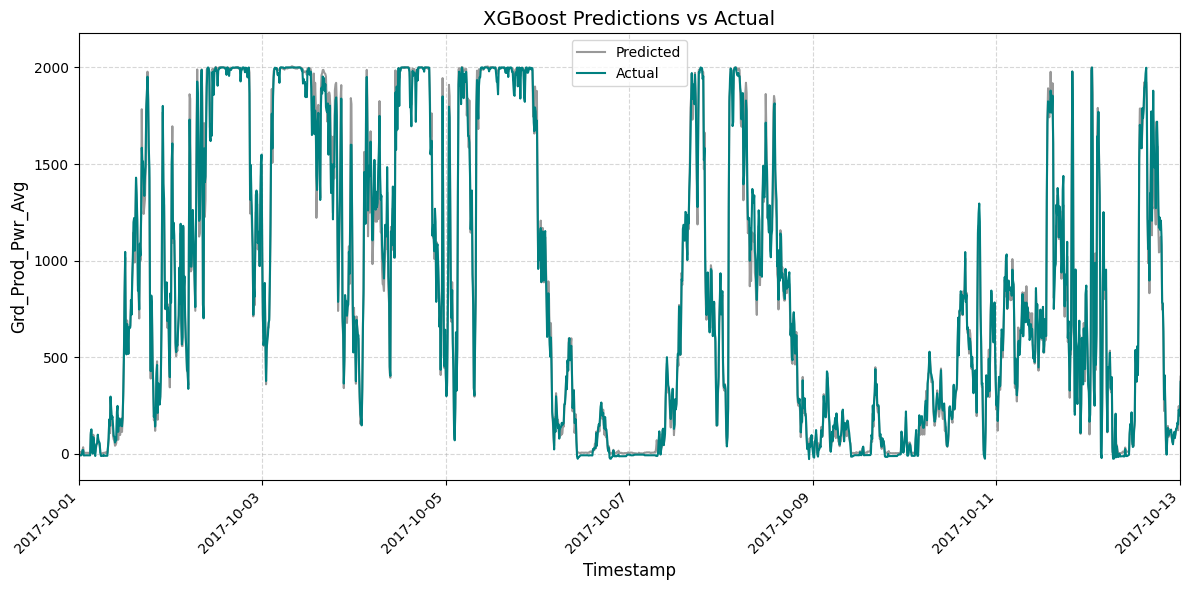

In [621]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [622]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for hybrid model predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["p_hybrid"],  # Hybrid model predictions
    color='grey', alpha=0.8, label='Hybrid Model', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))
# Title and labels
plt.title("Hybrid Model Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()"""


'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])\n\n# Sort merged_df17 by "Timestamp" for better visualization\nmerged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")\n\nplt.figure(figsize=(12, 6))\n\n# Line plot for hybrid model predictions\nplt.plot(\n    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps\n    merged_df_filtered17_sorted["p_hybrid"],  # Hybrid model predictions\n    color=\'grey\', alpha=0.8, label=\'Hybrid Model\', linestyle=\'-\', linewidth=1.5\n)\n\n# Line plot for actual values\nplt.plot(\n    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps\n    merged_df_filtered17_sorted[target_column],  # Actual target values\n    color=\'teal\', alpha=1, label=\'Actual\', linestyle=\'-\', linewidth=1.5\n)\n\n# Highlight x-axis labels for better readability\nplt.xticks(rotation=45, ha=\'right\')\n\n# Define inter

Replication of maneesh work to see if data is faulty after maintenance in

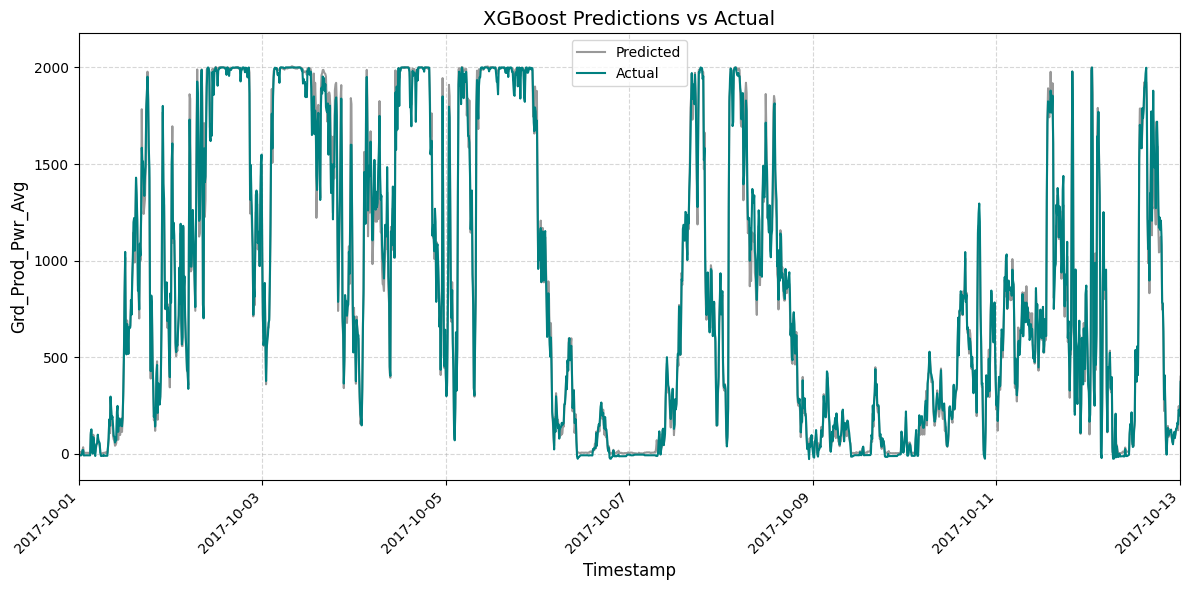

In [623]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='grey', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='teal', alpha=1, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


(np.float64(17324.0), np.float64(17525.0))

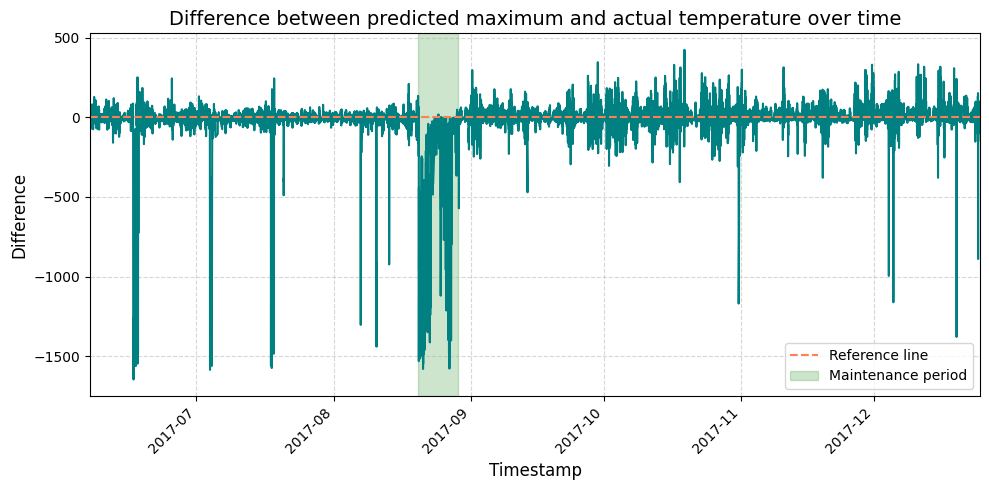

In [624]:
merged_df_filtered17_sorted["xgb_actual_diff"] =  merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["xgboost_pred_2017"]

plt.plot(merged_df_filtered17_sorted["Timestamp"],merged_df_filtered17_sorted["xgb_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")
# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")
# Configure plot
plt.title("Difference between predicted maximum and actual temperature over time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

<Axes: >

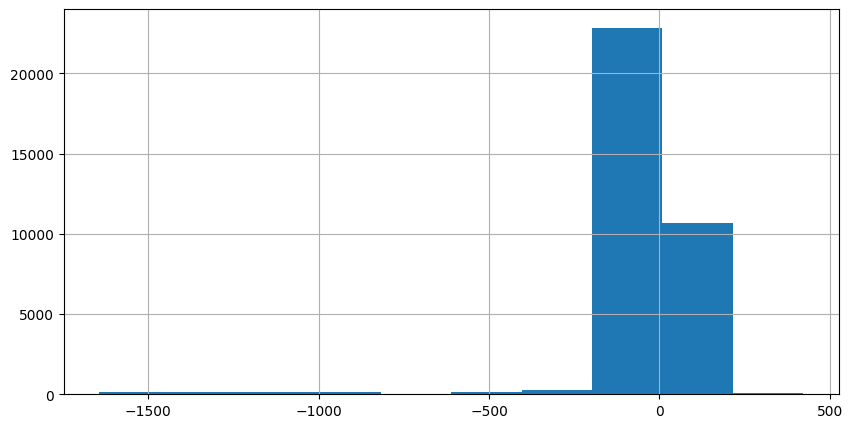

In [625]:
merged_df_filtered17_sorted["xgb_actual_diff"].hist()

In [626]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Compute the difference between actual and predicted values for the hybrid model
merged_df_filtered17_sorted["hybrid_actual_diff"] = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["p_hybrid"]

# Plot the difference over time
plt.plot(merged_df_filtered17_sorted["Timestamp"], merged_df_filtered17_sorted["hybrid_actual_diff"], color="teal")

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Reference line")

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Configure plot
plt.title("Difference between Predicted and Actual Temperature Over Time (Hybrid Model)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Difference", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Set x-axis limits
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

plt.show()"""


'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Compute the difference between actual and predicted values for the hybrid model\nmerged_df_filtered17_sorted["hybrid_actual_diff"] = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted["p_hybrid"]\n\n# Plot the difference over time\nplt.plot(merged_df_filtered17_sorted["Timestamp"], merged_df_filtered17_sorted["hybrid_actual_diff"], color="teal")\n\n# Add reference line for anomaly threshold\nplt.axhline(y=0, color=\'coral\', linestyle="--", label="Reference line")\n\n# Add green shaded region between specified dates\nplt.axvspan(pd.to_datetime(\'2017-08-20\'), pd.to_datetime(\'2017-08-29\'), color=\'green\', alpha=0.2, label="Maintenance period")\n\n# Configure plot\nplt.title("Difference between Predicted and Actual Temperature Over Time (Hybrid Model)", fontsize=14)\nplt.xlabel("Timestamp", fontsize=12)\nplt.ylabel("Difference", fontsize=12)\nplt.legend(fontsize=10)\nplt.grid(True, linestyle=\'--\', alph

Test of wide interval without uncertainty

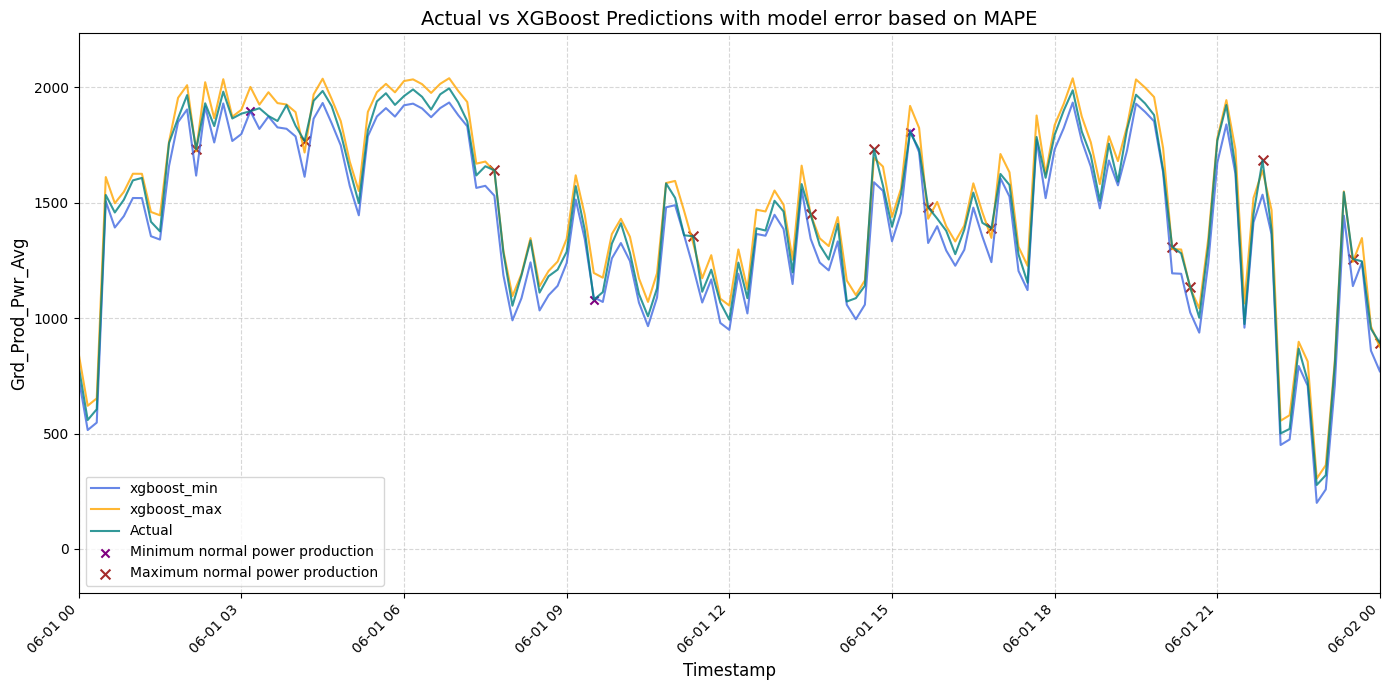

In [627]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define min and max bounds using xgboost predictions
merged_df_filtered17_sorted["xgboost_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] -modelling_error
merged_df_filtered17_sorted["xgboost_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] +modelling_error


# Identify where actual values exceed bounds
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["xgboost_min"])
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["xgboost_max"])

# Start plotting
plt.figure(figsize=(14, 7))

# Plot min and max bounds
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_min"],
    color='royalblue', alpha=0.8, label='xgboost_min', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_max"],
    color='orange', alpha=0.8, label='xgboost_max', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["below_min"], target_column],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

plt.scatter(
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], "Timestamp"],
    merged_df_filtered17_sorted.loc[merged_df_filtered17_sorted["above_max"], target_column],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)


# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-01'), pd.to_datetime('2017-06-02'))
plt.title("Actual vs XGBoost Predictions with model error based on MAPE", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


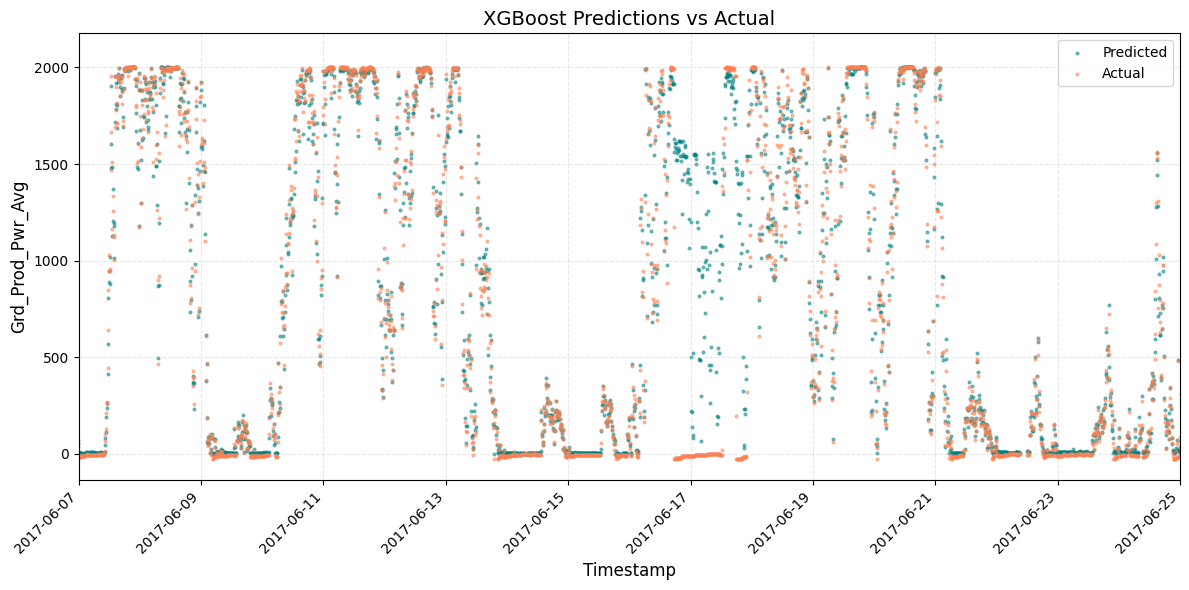

In [628]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


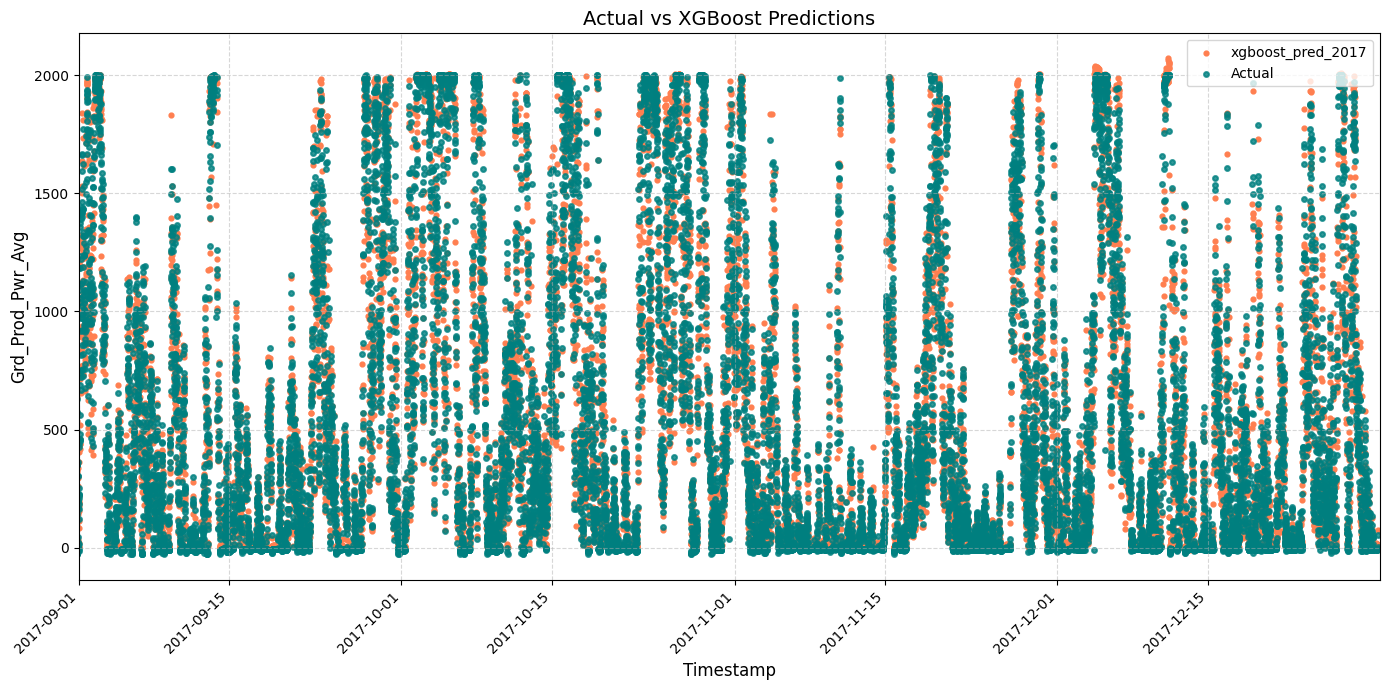

In [629]:
# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Start plotting
plt.figure(figsize=(14, 7))

# Scatter plot for xgboost predictions
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["xgboost_pred_2017"],
    color='coral', marker='o', s=12, label='xgboost_pred_2017'
)

# Line plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted[target_column],
    color='teal', alpha=0.8, s=12,label='Actual', linestyle='-', linewidth=1.5
)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-09-01'), pd.to_datetime('2017-12-31'))
plt.title("Actual vs XGBoost Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Intervals:

In [630]:
# check units of the independent variables to make sure that interval is correctly chosen:
["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]
# Get a statistical summary for the other columns

windspeed_summary = merged_df_filtered17_sorted["Avg_Windspeed1"].describe()
nac_temp_summary = merged_df_filtered17_sorted["Nac_Temp_Avg"].describe()
humidity_summary = merged_df_filtered17_sorted["Avg_Humidity"].describe()
print(f"Avg Windspeed Summary:\n{windspeed_summary}")
print(f"Nac Temp Avg Summary:\n{nac_temp_summary}")
print(f"Avg Humidity Summary:\n{humidity_summary}")


Avg Windspeed Summary:
count    34581.000000
mean         6.257465
std          3.527416
min          0.000000
25%          3.600000
50%          5.600000
75%          8.400000
max         23.100000
Name: Avg_Windspeed1, dtype: float64
Nac Temp Avg Summary:
count    34582.000000
mean        31.666994
std          5.829491
min         17.000000
25%         28.000000
50%         32.000000
75%         36.000000
max         50.000000
Name: Nac_Temp_Avg, dtype: float64
Avg Humidity Summary:
count    34582.000000
mean        63.366694
std         17.430912
min         11.000000
25%         51.000000
50%         65.000000
75%         77.000000
max         99.000000
Name: Avg_Humidity, dtype: float64


In [631]:
# Define intervals for each feature
Amb_Temp_interval = [-2, 2]         # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-1, 1]          # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-1, 1]        # m/s (for Amb_WindSpeed_Avg)
Humidity_interval = [-2, 2]     # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]         # hPa? (for Avg_Pressure)


In [632]:
# Calculate maximum values by adding the max of each interval to the average values
merged_df_filtered17_sorted["max_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] + max(Amb_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + max(Windspeed_interval)
merged_df_filtered17_sorted["max_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(Humidity_interval)
merged_df_filtered17_sorted["max_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] + max(Pressure_interval)

# Calculate minimum values by adding the min of each interval to the average values
merged_df_filtered17_sorted["min_Amb_Temp_Avg"] = merged_df_filtered17_sorted["Amb_Temp_Avg"] - min(Amb_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM_Avg"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] - min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Amb_WindSpeed_Avg"] = merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] - min(Windspeed_interval)
merged_df_filtered17_sorted["min_Avg_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] - min(Humidity_interval)
merged_df_filtered17_sorted["min_Avg_Pressure"] = merged_df_filtered17_sorted["Avg_Pressure"] - min(Pressure_interval)


In [633]:
print(model.get_booster().feature_names)

['Avg_Pressure', 'Avg_Humidity', 'Amb_Temp_Avg', 'Gen_RPM_Avg', 'Amb_WindSpeed_Avg']


In [634]:
merged_df["Avg_Pressure"]

0        1005
1        1005
2        1005
3        1006
4        1005
         ... 
35765    1018
35766    1002
35767    1002
35768    1003
35769    1003
Name: Avg_Pressure, Length: 35770, dtype: int64

### migght do this instead later:

In [635]:
import pandas as pd
import itertools

# Define intervals for each feature
Amb_Temp_interval = [-2, 2]        # degrees (for Amb_Temp_Avg)
Gen_RPM_interval = [-1, 1]         # RPM (for Gen_RPM_Avg)
Windspeed_interval = [-1, 1]       # m/s (for Amb_WindSpeed_Avg)
Humidity_interval = [-2, 2]    # percentage (for Avg_Humidity)
Pressure_interval = [-1, 1]        # hPa? (for Avg_Pressure)

# Generate all 32 combinations of interval adjustments
combinations = list(itertools.product(
    Amb_Temp_interval,
    Gen_RPM_interval,
    Windspeed_interval,
    Humidity_interval,
    Pressure_interval
))

# Iterate through the 32 combinations
for idx, combo in enumerate(combinations):
    Amb_Temp_val, Gen_RPM_val, WindSpeed_val, Humidity_val, Pressure_val = combo

    # Apply the combination adjustments to the time series
X_test = pd.DataFrame({
    'Amb_Temp_Avg': merged_df_filtered17_sorted["Amb_Temp_Avg"] + Amb_Temp_val,
    'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
    'Amb_WindSpeed_Avg': merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] + WindSpeed_val,
    'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + Humidity_val,
    'Avg_Pressure': merged_df_filtered17_sorted["Avg_Pressure"] + Pressure_val
})

# Ensure the order of columns matches the training set
X_test = X_test[feature_columns]  # This fixes the issue

# Predict with the model for the entire time series
predictions = model.predict(X_test)

# Store predictions in the DataFrame
merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

print(f"Combination {idx+1}: Prediction completed for the entire time series.")


# Optionally, save or visualize the modified DataFrame
# merged_df_filtered17_sorted.to_csv('predictions_with_combinations.csv', index=False)


Combination 32: Prediction completed for the entire time series.


## Only sensor error:

C:\Users\thors\AppData\Local\Temp\ipykernel_8768\8437922.py:49: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=10)  # Adjusts the number of x-axis labels


(np.float64(17324.0), np.float64(17342.0))

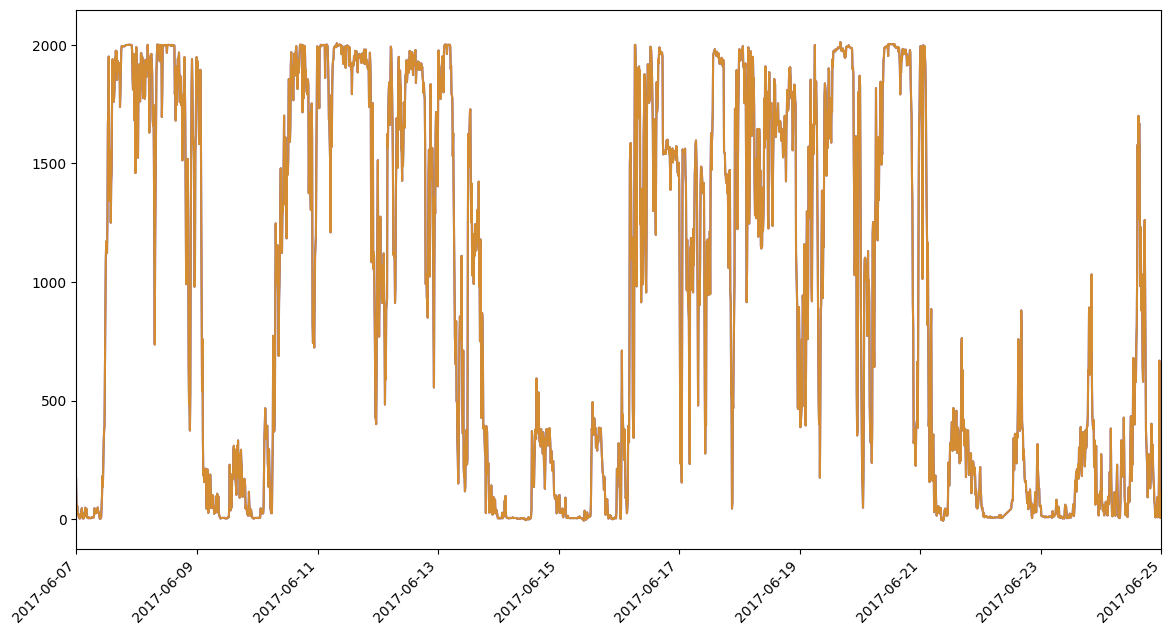

In [636]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort DataFrame by Timestamp for chronological order
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot min and max predictions over time
plt.figure(figsize=(14, 7))

# Shaded area between min and max predictions for clarity
plt.fill_between(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    merged_df_filtered17_sorted["row_max"], 
    color='gray', alpha=0.3, label="Prediction Range"
)

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Set x-axis labels to be more readable
plt.xticks(rotation=45, ha='right')

# Reduce the number of x-axis ticks for better readability
plt.locator_params(axis='x', nbins=10)  # Adjusts the number of x-axis labels

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

#


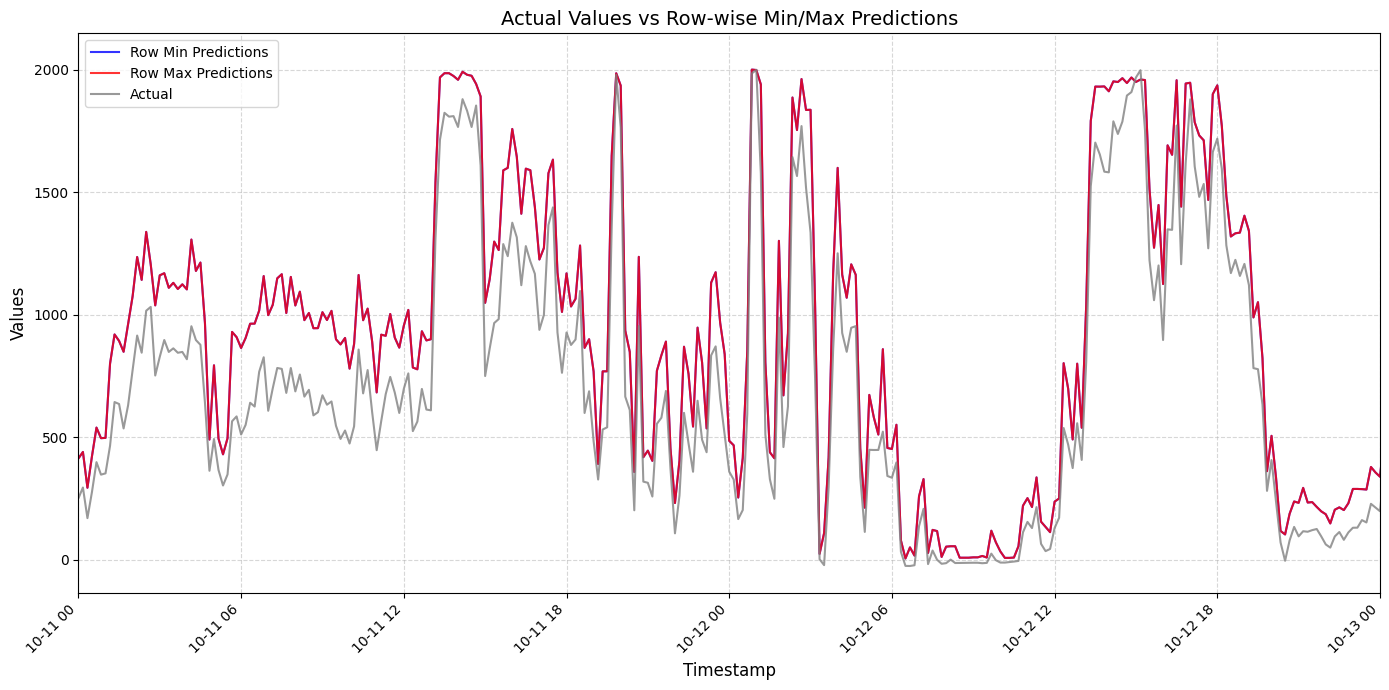

In [637]:


# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-10-11'), pd.to_datetime('2017-10-13'))

# Title and labels
plt.title("Actual Values vs Row-wise Min/Max Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


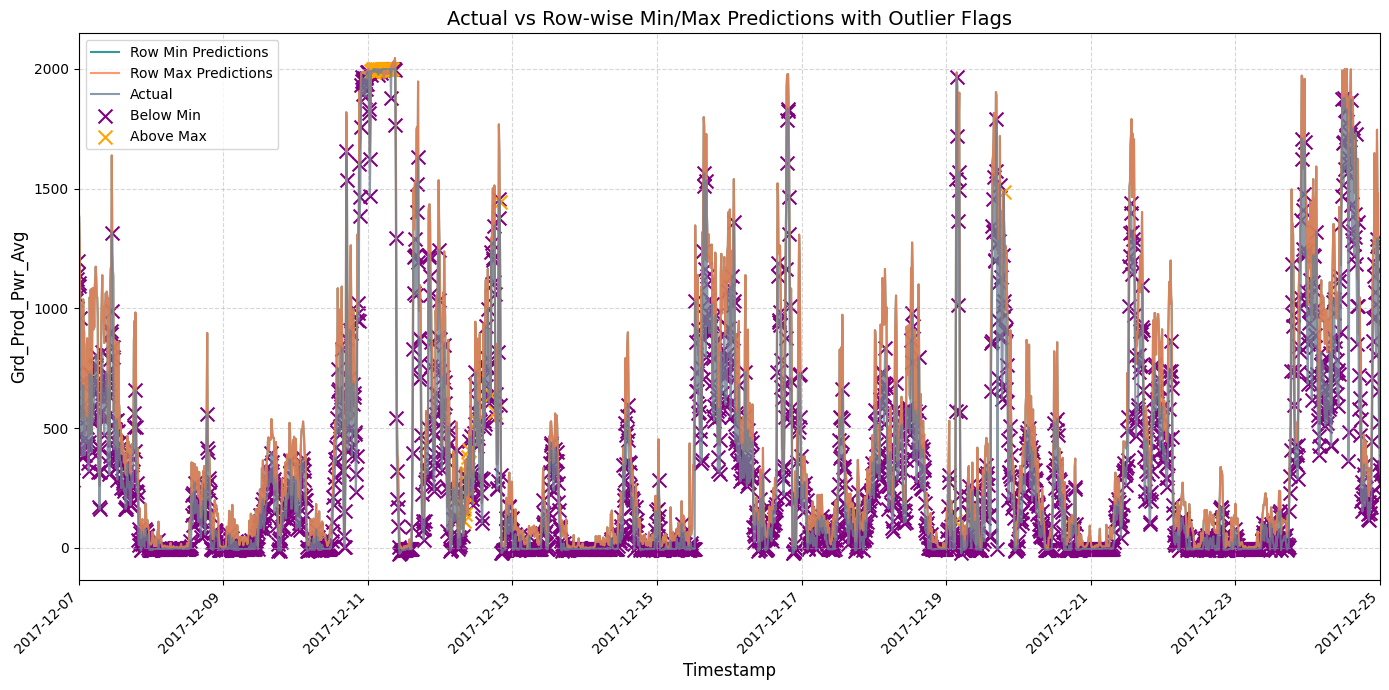

In [638]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)



# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]).astype(int)



# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='teal', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='coral', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='slategrey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label='Below Min'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label='Above Max'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Outlier Flags", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


## Adjust maximum power production here:

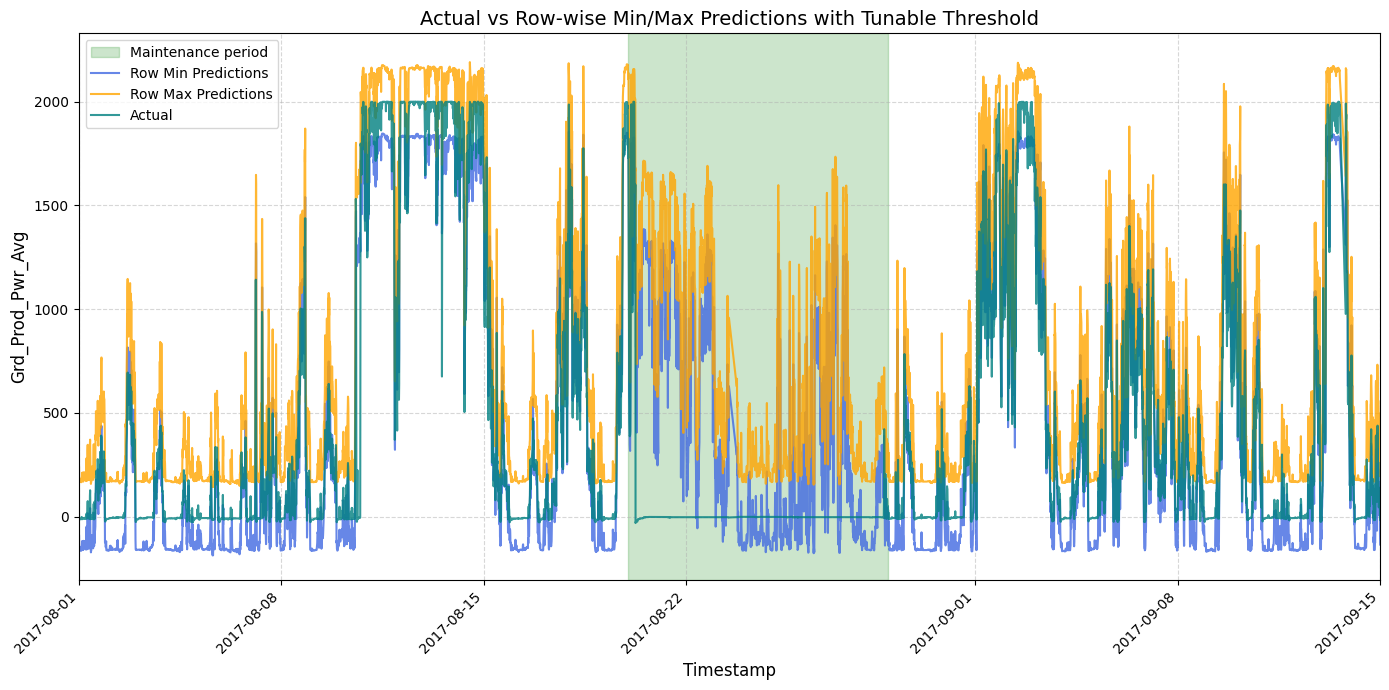

In [639]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Add green shaded region between specified dates
plt.axvspan(pd.to_datetime('2017-08-20'), pd.to_datetime('2017-08-29'), color='green', alpha=0.2, label="Maintenance period")

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

"""# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='coral', marker='x', s=50, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Max + {threshold}'
)"""

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2017-09-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [640]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)


# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=50, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production '
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-15'), pd.to_datetime('2017-06-17'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for prediction columns\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)\n\n\n# Flag where actual values are outside the row-wise min and max with a thres

In [641]:
modelling_error_xgboost

np.float64(165.03094396018983)

In [642]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")


# Identify prediction columns generated by the hybrid model (e.g., hybrid_pred_comb_1, hybrid_pred_comb_2, ...)
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for the hybrid model predictions
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost)
).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"] - modelling_error_xgboost, 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + modelling_error_xgboost, 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values (target column)
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold (anomalies below the minimum)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label='Below Minimum Power Production'
)

# Scatter points where actual is above row_max + threshold (anomalies above the maximum)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label='Above Maximum Power Production'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-08-02'), pd.to_datetime('2017-09-03'))  # Example date range

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust layout to prevent clipping
plt.tight_layout()  
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n\n# Identify prediction columns generated by the hybrid model (e.g., hybrid_pred_comb_1, hybrid_pred_comb_2, ...)\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for the hybrid model predictions\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max

In [643]:
[col for col in merged_df_filtered17_sorted.columns if col.startswith('hybrid_pred_comb_')]

[]

In [644]:
merged_df_filtered17_sorted[prediction_columns].max(axis=1) 

52211    517.015198
12009    429.501770
81550    490.433655
32490    474.949158
5835     416.099152
            ...    
30058    816.048767
57112    587.315918
9296     379.564148
84976    356.024139
22499    443.801300
Length: 34582, dtype: float32

## XGBoost model plotting

In [645]:
"""# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for sensor variational error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1) - (modelling_error)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1) + (modelling_error)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] )
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] )
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Minimum normal power production', alpha=0.6
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=35, label=f'Maximum normal power production', alpha=0.6
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-10'), pd.to_datetime('2017-06-15'))


# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions (XGBoost)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
"""

'# Checking other dates of the year when the turbine generator is in healthy condition:\n\nimport matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n# Define tunable threshold\n# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for sensor variational error\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_colum

In [646]:
"""import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute sensor variation (based on deviation from actual prediction)
sensor_min_deviation = (merged_df_filtered17_sorted[prediction_columns].min(axis=1) - merged_df_filtered17_sorted[target_column]).abs()
sensor_max_deviation = (merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted[target_column]).abs()

# Combine modelling error and sensor variation using root-sum-square (RSS)
row_min_deviation = np.sqrt(sensor_min_deviation**2 + modelling_error**2)
row_max_deviation = np.sqrt(sensor_max_deviation**2 + modelling_error**2)

# Final row-wise bounds
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[target_column] - row_min_deviation
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[target_column] + row_max_deviation

# Flag where actual values are outside the bounds
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]
).astype(int)

# Plotting
plt.figure(figsize=(14, 7))

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label='Minimum normal power production', alpha=0.3
)

plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=35, label='Maximum normal power production', alpha=0.3
)

plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-10'), pd.to_datetime('2017-06-15'))

plt.title("Actual vs Row-wise Min/Max Predictions (XGBoost)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute sensor variation (based on deviation from actual prediction)\nsensor_min_deviation = (merged_df_filtered17_sorted[prediction_columns].min(axis=1) - merged_df_filtered17_sorted[target_column]).abs()\nsensor_max_deviation = (merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted[target_column]).abs()\n\n# Combine modellin

In [647]:
"""import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")



# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Define actual values
timestamps = merged_df_filtered17_sorted["Timestamp"]
actual_values = merged_df_filtered17_sorted[target_column]
upper_bound = merged_df_filtered17_sorted["row_max"] + modelling_error
# Start plotting
plt.figure(figsize=(14, 7))

# Plot row-wise min and max thresholds
plt.plot(timestamps, merged_df_filtered17_sorted["row_min"] - modelling_error, color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5)
plt.plot(timestamps, upper_bound, color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5)

# Dynamically change color of the actual line
prev_above = False
for i in range(len(timestamps) - 1):
    current_above = actual_values.iloc[i] > upper_bound.iloc[i]
    
    if i == 0 or current_above != prev_above:
        plt.plot(
            timestamps[i : i + 2], 
            actual_values.iloc[i : i + 2], 
            color='blue' if current_above else 'teal', 
            linewidth=1.5
        )
    else:
        plt.plot(
            timestamps[i : i + 2], 
            actual_values.iloc[i : i + 2], 
            color='red' if current_above else 'slategrey', 
            linewidth=1.5
        )
    
    prev_above = current_above

# Formatting
plt.xticks(rotation=45, ha='right')
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for prediction columns\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)\n\n# Define actual values\ntimestamps = merged_df_filtered17_

### Start: Plots without sensor error

In [648]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define the XGBoost prediction column (without sensor variations)
xgboost_pred_column = "xgboost_pred_2017"

# Compute row-wise min and max **only based on modeling error**
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[xgboost_pred_column] - (modelling_error)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[xgboost_pred_column] + (modelling_error)

# Flag where actual values are outside the row-wise min and max with the threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]
).astype(int)

merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Below Model Prediction Range'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Above Model Prediction Range'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.title("Actual vs Row-wise Min/Max Predictions from Modelling Error, ML model", fontsize=14)
# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-09-22'), pd.to_datetime('2017-09-24'))

"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n# Define the XGBoost prediction column (without sensor variations)\nxgboost_pred_column = "xgboost_pred_2017"\n\n# Compute row-wise min and max **only based on modeling error**\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[xgboost_pred_column] - (modelling_error)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[xgboost_pred_column] + (modelling_error)\n\n# Flag where actual values are outside the row-wise min and max with the threshold\nmerged_df_filtered17_sorted["below_min"] = (\n    merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]\n).astype(int)\n\nmerged_df_filtered17_sorted["

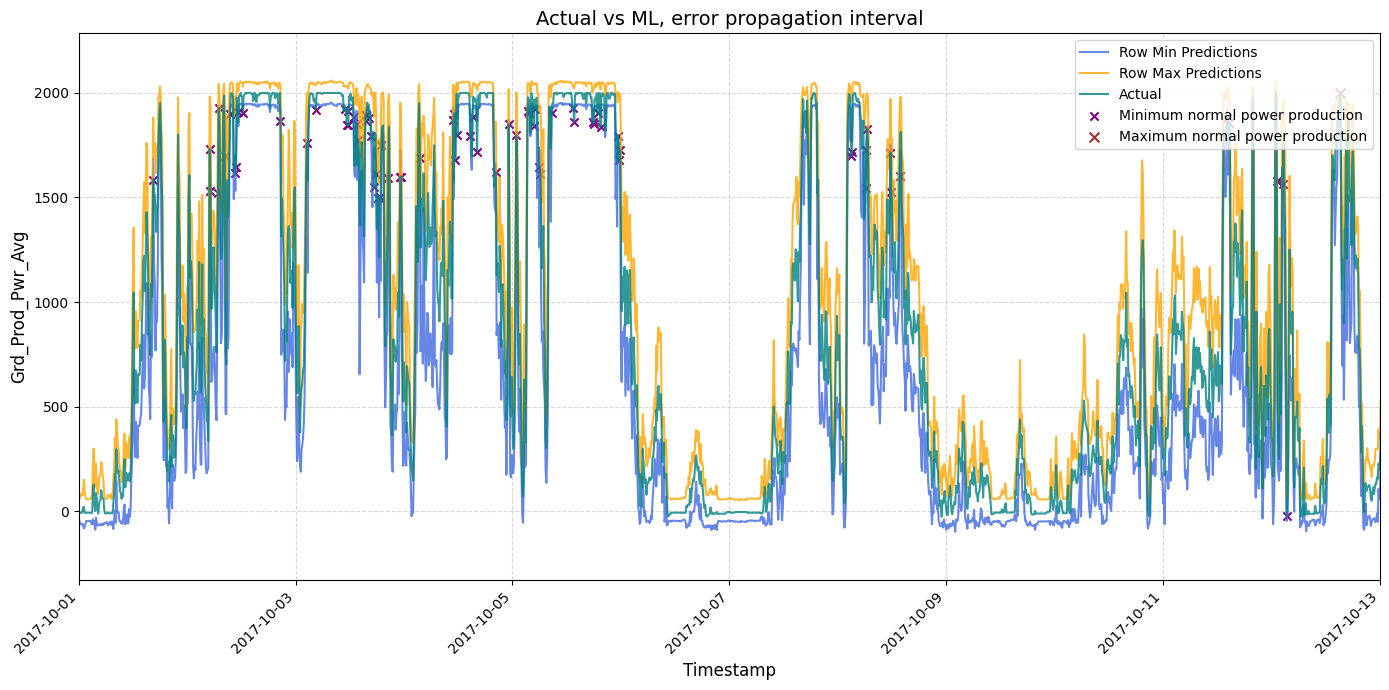

In [ ]:
# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
# Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Calculate deviation from actual prediction, then apply RSS with modelling error
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted["xgboost_pred_2017"] - np.sqrt((merged_df_filtered17_sorted["xgboost_pred_2017"] - merged_df_filtered17_sorted[prediction_columns].min(axis=1))**2 + modelling_error**2)

merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted["xgboost_pred_2017"] + np.sqrt((merged_df_filtered17_sorted[prediction_columns].max(axis=1) - merged_df_filtered17_sorted["xgboost_pred_2017"])**2 + modelling_error**2)


# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"])
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"])
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='royalblue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='orange', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='teal', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=35, label=f'Minimum normal power production'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='brown', marker='x', s=50, label=f'Maximum normal power production'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))


# Title and labels
plt.title("Actual power production vs ML, error propagation interval", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


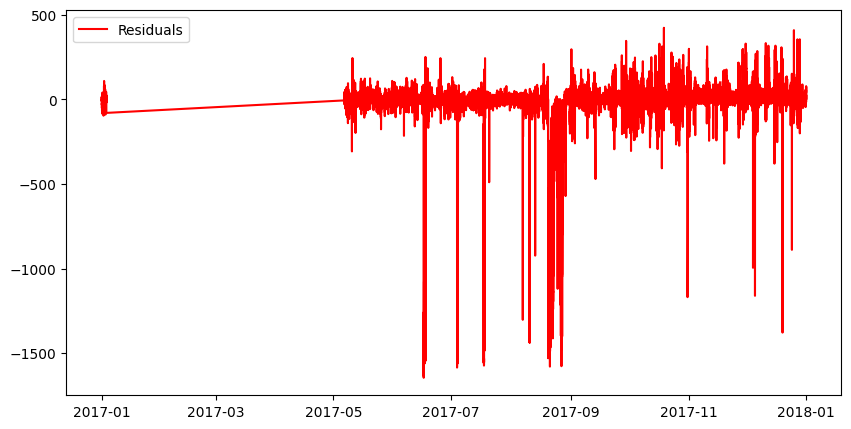

In [650]:
# Compute the modeling error dynamically (e.g., standard deviation of residuals)
residuals = merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted[xgboost_pred_column]
modelling_error = residuals.std()  # or any other metric like mean absolute error (MAE)

plt.plot(merged_df_filtered17_sorted["Timestamp"], residuals, color="red", label="Residuals")
plt.legend()


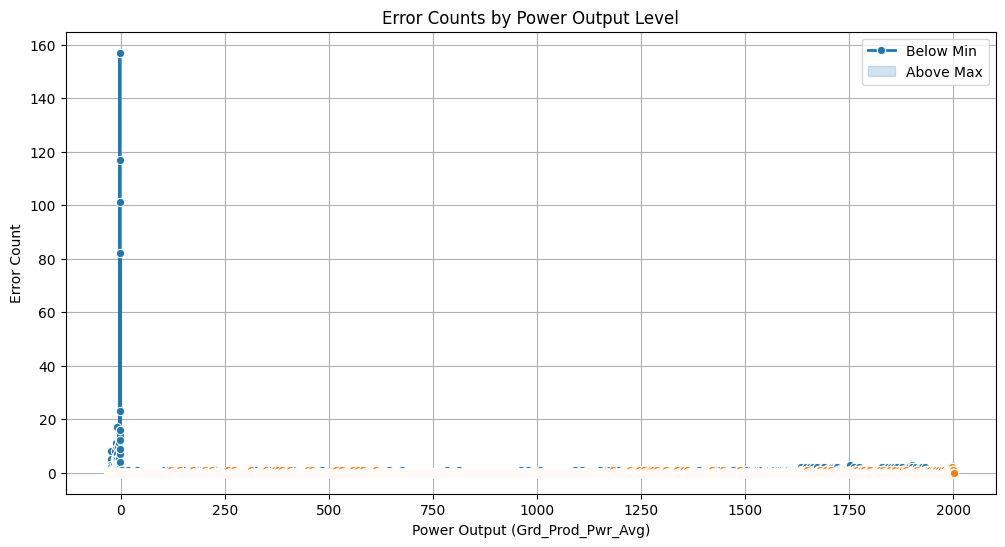

In [651]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residual errors
merged_df_filtered17_sorted["residual"] = (
    merged_df_filtered17_sorted[target_column] - merged_df_filtered17_sorted[xgboost_pred_column]
)

# Count errors (above_max and below_min) by power level
error_counts = merged_df_filtered17_sorted.groupby(target_column)[["below_min", "above_max"]].sum()

# Plot the error counts against power levels
plt.figure(figsize=(12, 6))
sns.lineplot(data=error_counts, marker="o", linewidth=2)
plt.xlabel("Power Output (Grd_Prod_Pwr_Avg)")
plt.ylabel("Error Count")
plt.title("Error Counts by Power Output Level")
plt.legend(["Below Min", "Above Max"])
plt.grid(True)
plt.show()


In [652]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
 # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - modelling_error)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + modelling_error)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-modelling_error, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+modelling_error, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {modelling_error}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {modelling_error}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies[target_column],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjusted for the timeframe from the plot you provided)
plt.xlim(pd.to_datetime('2017-10-01'), pd.to_datetime('2017-10-13'))


# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Power", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Ensure Timestamp column is in datetime format\nmerged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])\n\n# Sort the DataFrame by Timestamp\nmerged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")\n\n# Define tunable threshold\n # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)\n\n# Identify prediction columns\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure prediction columns are numeric\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for prediction columns\nmerged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[predictio

In [653]:
import matplotlib.pyplot as plt
import pandas as pd

# === Visualization ===
plt.figure(figsize=(14, 7))

# Plot diff_max_actual with time
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["diff_max_actual"], 
    color='teal', label="diff_max_actual"
)

# Add reference line for anomaly threshold
plt.axhline(y=0, color='coral', linestyle="--", label="Anomaly Threshold (0)")

# Configure plot
plt.title("Diff Max Actual Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Diff Max Actual", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Apply x-axis limits
plt.xlim(pd.to_datetime('2017-05-07'), pd.to_datetime('2017-12-25'))

# Show plot
plt.show()


KeyError: 'diff_max_actual'

<Figure size 1400x700 with 0 Axes>

In [ ]:
# Plot the feature with Timestamp on the x-axis and apply x-axis limits for better visibility
plt.figure(figsize=(14, 7))
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['diff_max_actual'], label='diff_max_actual', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold (0)')
plt.title('Feature Plot with Anomalies Over Time')
plt.xlabel('Timestamp')
plt.ylabel('diff_max_actual')
plt.legend()
plt.grid()

# Limiting the x-axis to show a specific portion of the data for clarity
plt.xlim(merged_df_filtered17_sorted['Timestamp'].iloc[0], 
         merged_df_filtered17_sorted['Timestamp'].iloc[100])  # Example: first 100 points
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Filter the data by date range
date_filtered_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= pd.to_datetime("2017-06-07").tz_localize("UTC")) &
    (merged_df_filtered17_sorted["Timestamp"] <= pd.to_datetime("2017-12-25").tz_localize("UTC"))
]
date_filtered_data.dropna(subset=["Gen_Bear_Temp_Avg", target_column, "Timestamp"])
# Use the smaller dataset for pairwise calculations
temperature_data = date_filtered_data["Gen_Bear_Temp_Avg"].values
actual = date_filtered_data["Gen_Bear_Temp_Avg"].values
predicted = date_filtered_data[target_column].values
timestamps = date_filtered_data["Timestamp"].values

In [ ]:
# Combine predicted and actual values into a DataFrame for cleaning
data_for_clustering = pd.DataFrame({
    "predicted": predicted,
    "actual": actual
})

# Drop rows with NaN values
data_for_clustering.dropna(inplace=True)

# Convert back to NumPy array
data_for_clustering = data_for_clustering.values

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(data_for_clustering)

# Assign cluster labels back to the original DataFrame
date_filtered_data = date_filtered_data.iloc[:len(data_for_clustering)].copy()  # Adjust length to match cleaned data
date_filtered_data["DBSCAN_Cluster"] = dbscan.labels_

# Visualize DBSCAN clusters
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(dbscan.labels_):
    cluster_points = date_filtered_data[date_filtered_data["DBSCAN_Cluster"] == cluster_id]
    plt.scatter(
        cluster_points[target_column],  # X: Predicted
        cluster_points["Gen_Bear_Temp_Avg"],  # Y: Actual
        label=f"Cluster {cluster_id}" if cluster_id != -1 else "Outliers"
    )

plt.plot(predicted, predicted, color="red", linestyle="--", label="Prediction Reference Line")
plt.title("DBSCAN Clustering: Actual vs Predicted")
plt.xlabel("Predicted Temperature")
plt.ylabel("Actual Temperature")
plt.legend()
plt.grid()
plt.show()



In [ ]:
date_filtered_data['Rolling_Mean'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).mean()
date_filtered_data['Rolling_Std'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).std()
date_filtered_data['Anomaly'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - date_filtered_data['Rolling_Mean']) > 2 * date_filtered_data['Rolling_Std']


In [ ]:
from scipy.stats import zscore
date_filtered_data['Z_Score'] = zscore(date_filtered_data['Gen_Bear_Temp_Avg'])
date_filtered_data['Anomaly_Z_Score'] = abs(date_filtered_data['Z_Score']) > 2


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Z_Score']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Z_Score']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Z-Score")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


Additional isolation forrest

In [ ]:
# Drop rows with missing values in 'Gen_Bear_Temp_Avg'
merged_df_filtered17_sorted = merged_df_filtered17_sorted.dropna(subset=['Gen_Bear_Temp_Avg'])

# Now proceed with LOF model
from sklearn.neighbors import LocalOutlierFactor

# Define the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model and predict anomalies
X = merged_df_filtered17_sorted[['Gen_Bear_Temp_Avg']]  # Actual temperature data (or combine predicted and actual)
merged_df_filtered17_sorted['anomaly_lof'] = lof.fit_predict(X)
merged_df_filtered17_sorted['anomaly_lof'] = merged_df_filtered17_sorted['anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by LOF
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_lof'] == 1]
plt.scatter(anomalies['Timestamp'], anomalies['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (LOF)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Local Outlier Factor (LOF)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-06-07'
end_date = '2017-10-25'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-12-07'
end_date = '2017-12-15'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
